Just for FUN!

将预测得到的涨跌幅作为因子（从结果来看这样不太可行）

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import warnings
warnings.simplefilter('ignore')

准备数据集

In [2]:
# 新增一个大盘数据集
# import jqdatasdk as jq
# jq.auth('USERNAME', 'PASSWORD')

# df_market = jq.get_price(security='000300.XSHG', start_date='2017-02-10', end_date='2022-03-31', frequency='daily')
# df_market['date'] = df_market.index
# df_market['date'] = df_market['date'].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
# df_market.reset_index(inplace=True)
# df_market['close_predict'] = df_market['close']
# df_market['return_predict'] = df_market['close_predict']/df_market['close_predict'].shift(1)-1
# df_market['code'] = '000300'
# df_market = df_market[['date', 'close_predict', 'close', 'code', 'return_predict']]

In [3]:
input_path = '/Users/ryan/Documents/GitHub/GDHF-Quant-Investment/test_data'
file_name = 'merged_table.csv'
input_file = os.path.join(input_path, file_name)

data = pd.read_csv(input_file)
data['TRADE_DT'] = pd.to_datetime(data['TRADE_DT'])
data.head(3)

,TRADE_DT,PREDICT_PR,TRUE_PR,CODE
0,2017-02-10,12.926414,6.03,601328_SH.gz
1,2017-02-13,13.045935,6.06,601328_SH.gz
2,2017-02-14,13.043993,6.06,601328_SH.gz


In [4]:
data['return_predict'] = data['PREDICT_PR']/data['PREDICT_PR'].shift(1)-1
# 这样计算会导致每只股票第一天的数据是由上一只股票最后一天的数据算出来的
# 做groupby会显得有些麻烦，在这里我们选择将第一行数据drop掉
data = data.groupby('CODE', group_keys=False).apply(lambda x: x.iloc[1:])
data.rename(columns={'TRADE_DT':'date', 'PREDICT_PR':'close_predict', 'TRUE_PR':'close',\
    'CODE':'code'}, inplace=True)
data['code'] = data['code'].str.split('_').apply(lambda x: x[0])
data.head(3)

,date,close_predict,close,code,return_predict
139049,2017-02-13,14.091991,9.41,000001,-0.012187
139050,2017-02-14,13.982758,9.40,000001,-0.007751
139051,2017-02-15,13.814657,9.45,000001,-0.012022


回测框架

**很不严谨的做法：** 用单因子回测框架对整体进行回测        
思路：将预测得到的收益率进行归一化处理（处理成因子的形式），再运用单因子回测框架获得结果。

In [5]:
data['factor_predict'] = data.groupby('code', group_keys=False).apply(lambda x: (x['return_predict']-x['return_predict'].min())/(x['return_predict'].max()-x['return_predict'].min()))
data.set_index('date', inplace=True)

Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000000,0.370948,0.266106,0.062100,66608,20.146270
2,0.258448,0.446676,0.381373,0.024985,65891,19.929406
3,0.375010,0.527515,0.451205,0.019796,65847,19.916098
4,0.458126,0.731381,0.514080,0.022965,65891,19.929406
5,0.522487,1.000000,0.638218,0.079478,66385,20.078821


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.032,-0.013,-0.009
beta,0.004,-0.007,-0.003
Mean Period Wise Return Top Quantile (bps),-1.328,-0.563,-0.058
Mean Period Wise Return Bottom Quantile (bps),1.752,0.999,1.284
Mean Period Wise Spread (bps),-3.080,-1.571,-1.349


<Figure size 432x288 with 0 Axes>

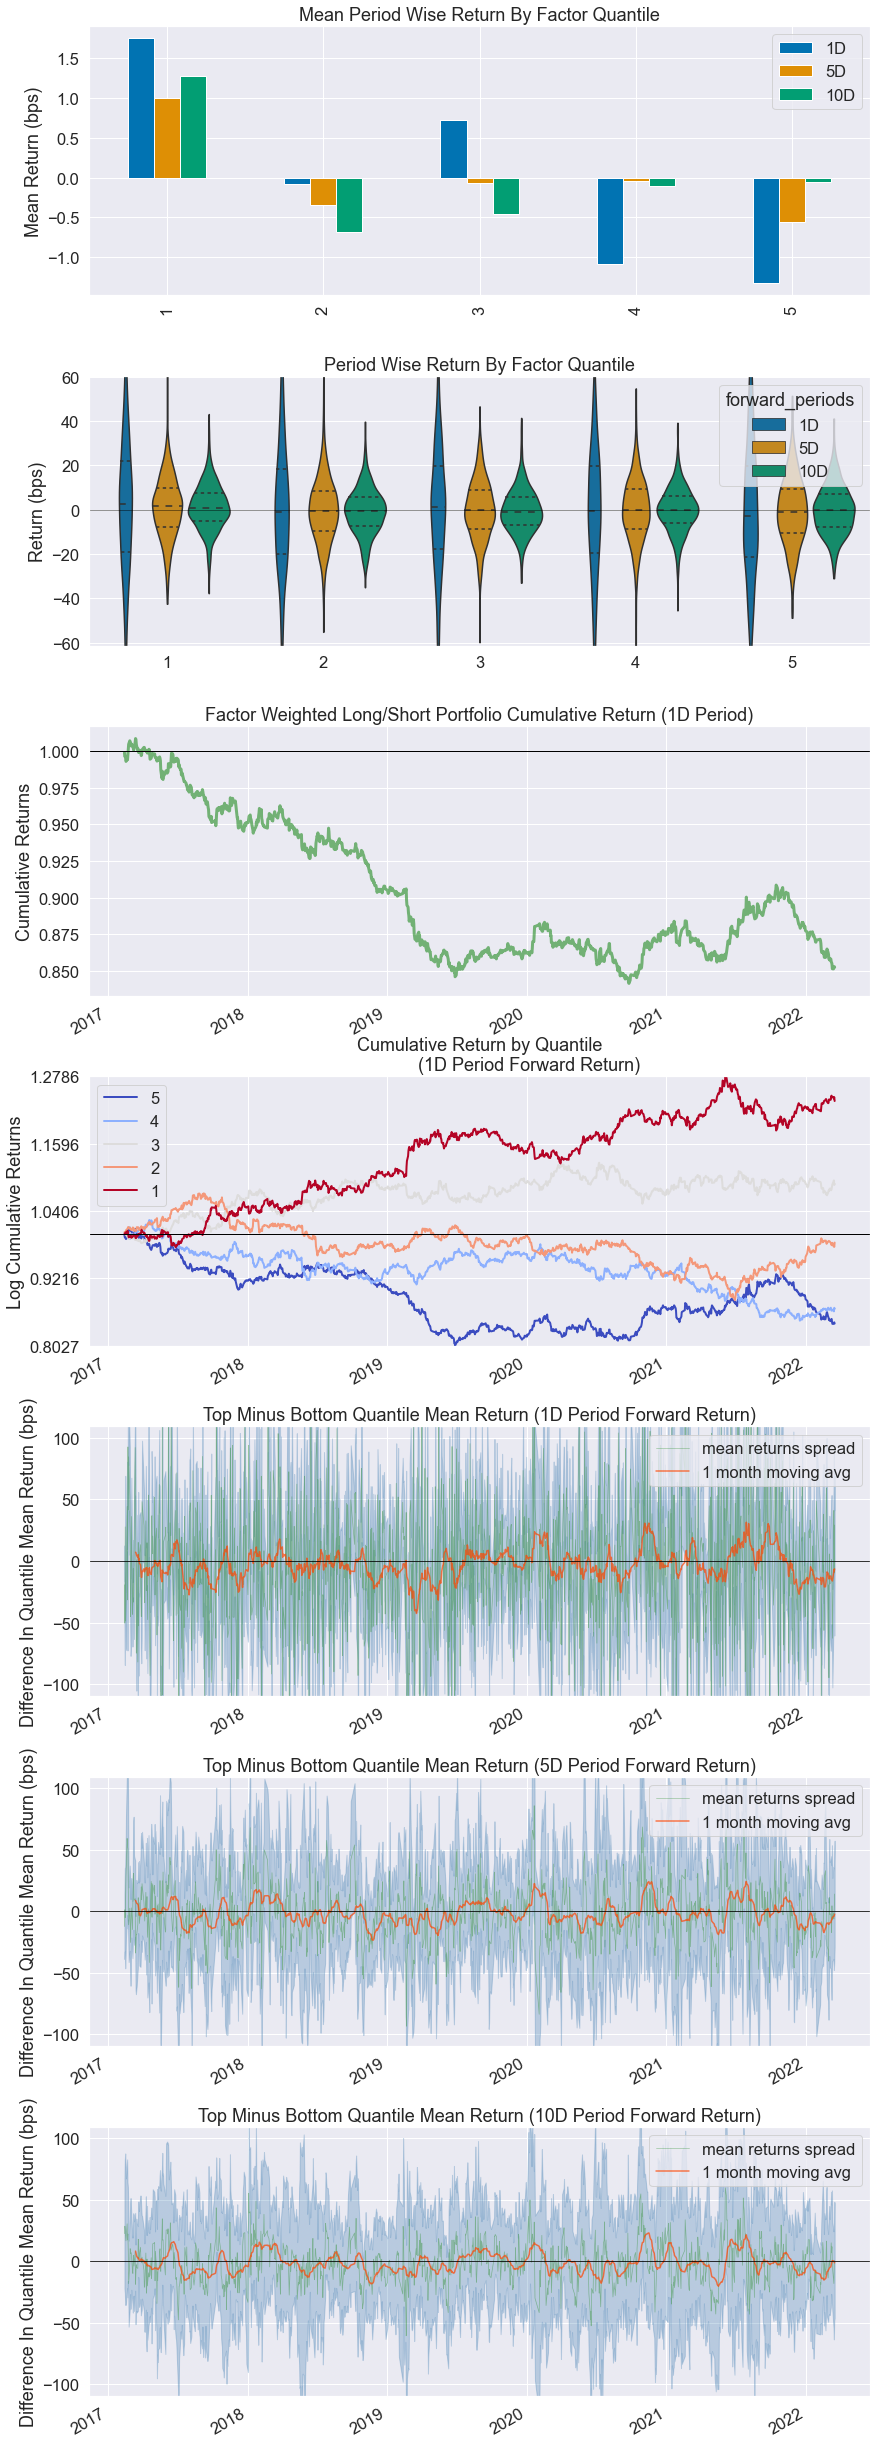

Information Analysis


,1D,5D,10D
IC Mean,-0.006,-0.005,-0.004
IC Std.,0.076,0.072,0.072
Risk-Adjusted IC,-0.076,-0.065,-0.061
t-stat(IC),-2.692,-2.299,-2.156
p-value(IC),0.007,0.022,0.031
IC Skew,-0.111,0.052,0.109
IC Kurtosis,0.196,0.166,0.136


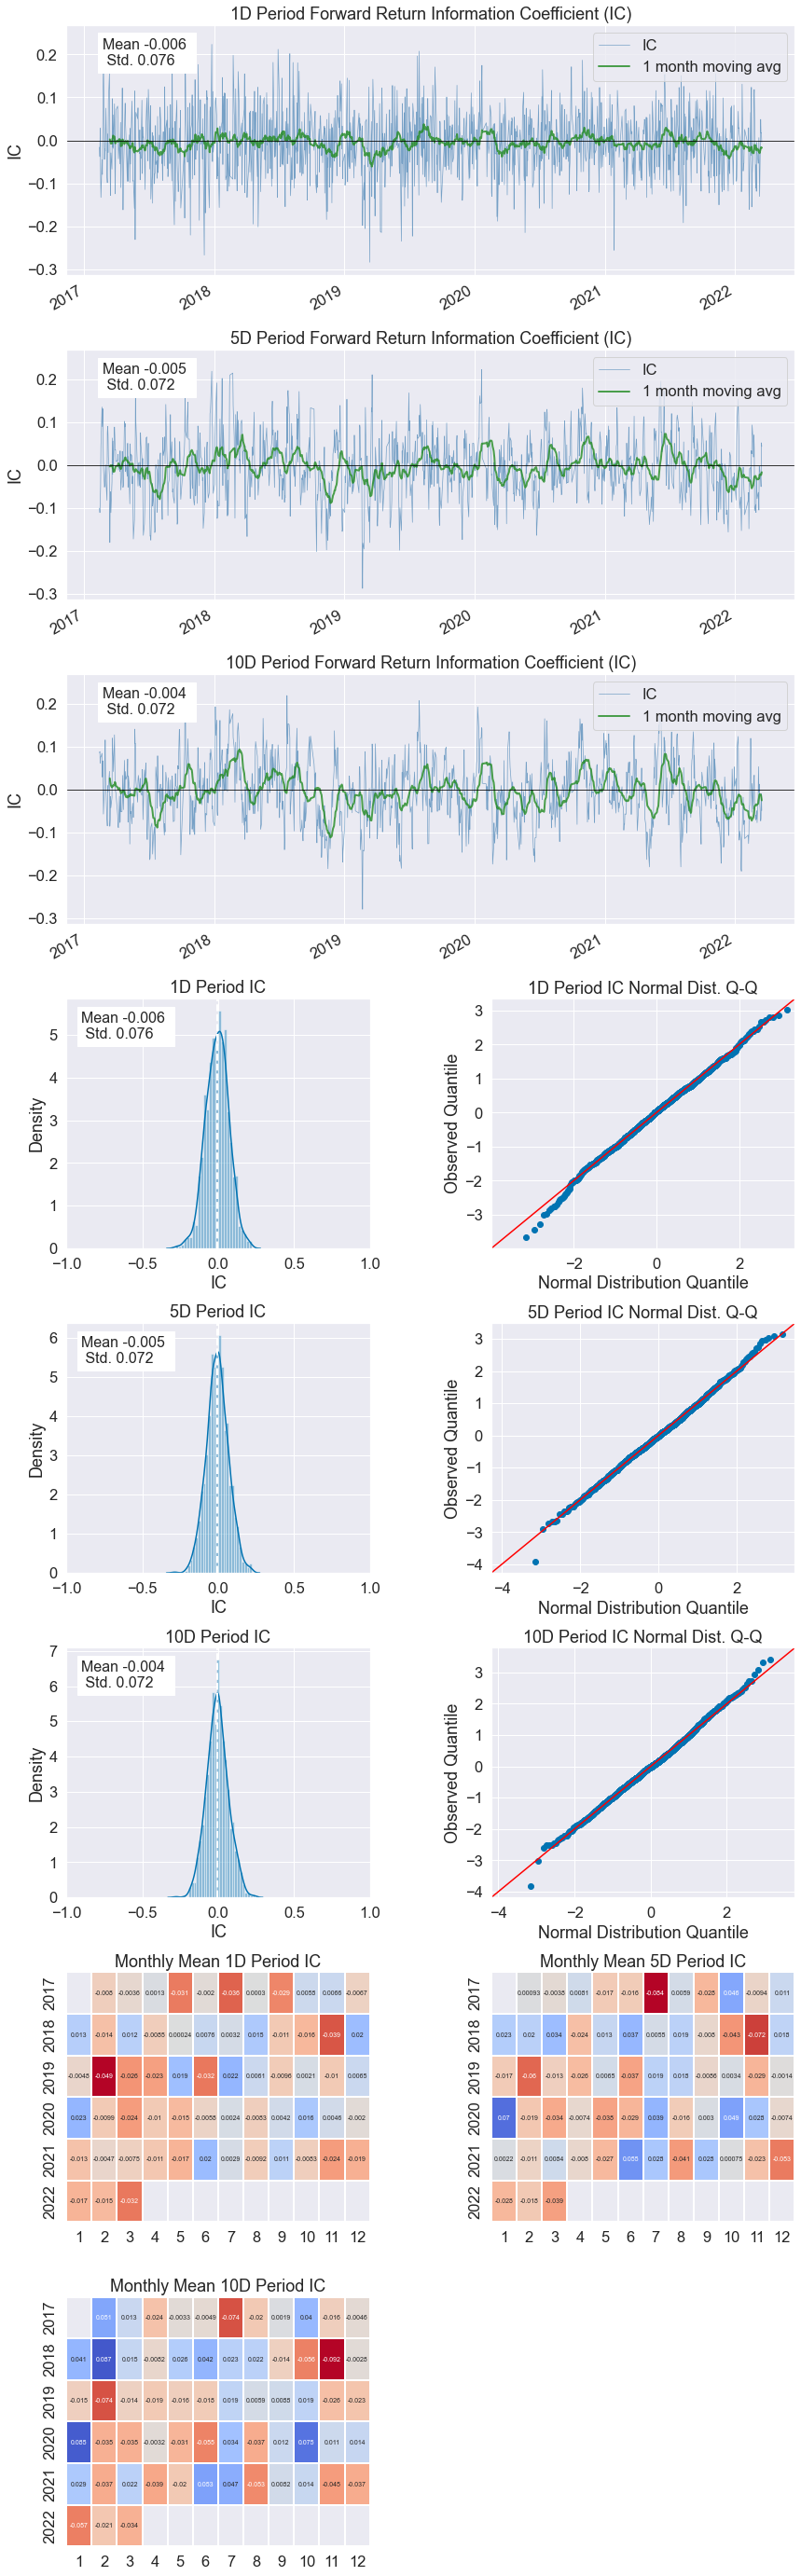

Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.249,0.384,0.368
Quantile 2 Mean Turnover,0.438,0.573,0.569
Quantile 3 Mean Turnover,0.486,0.616,0.615
Quantile 4 Mean Turnover,0.445,0.574,0.575
Quantile 5 Mean Turnover,0.272,0.432,0.412


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.806,0.616,0.654


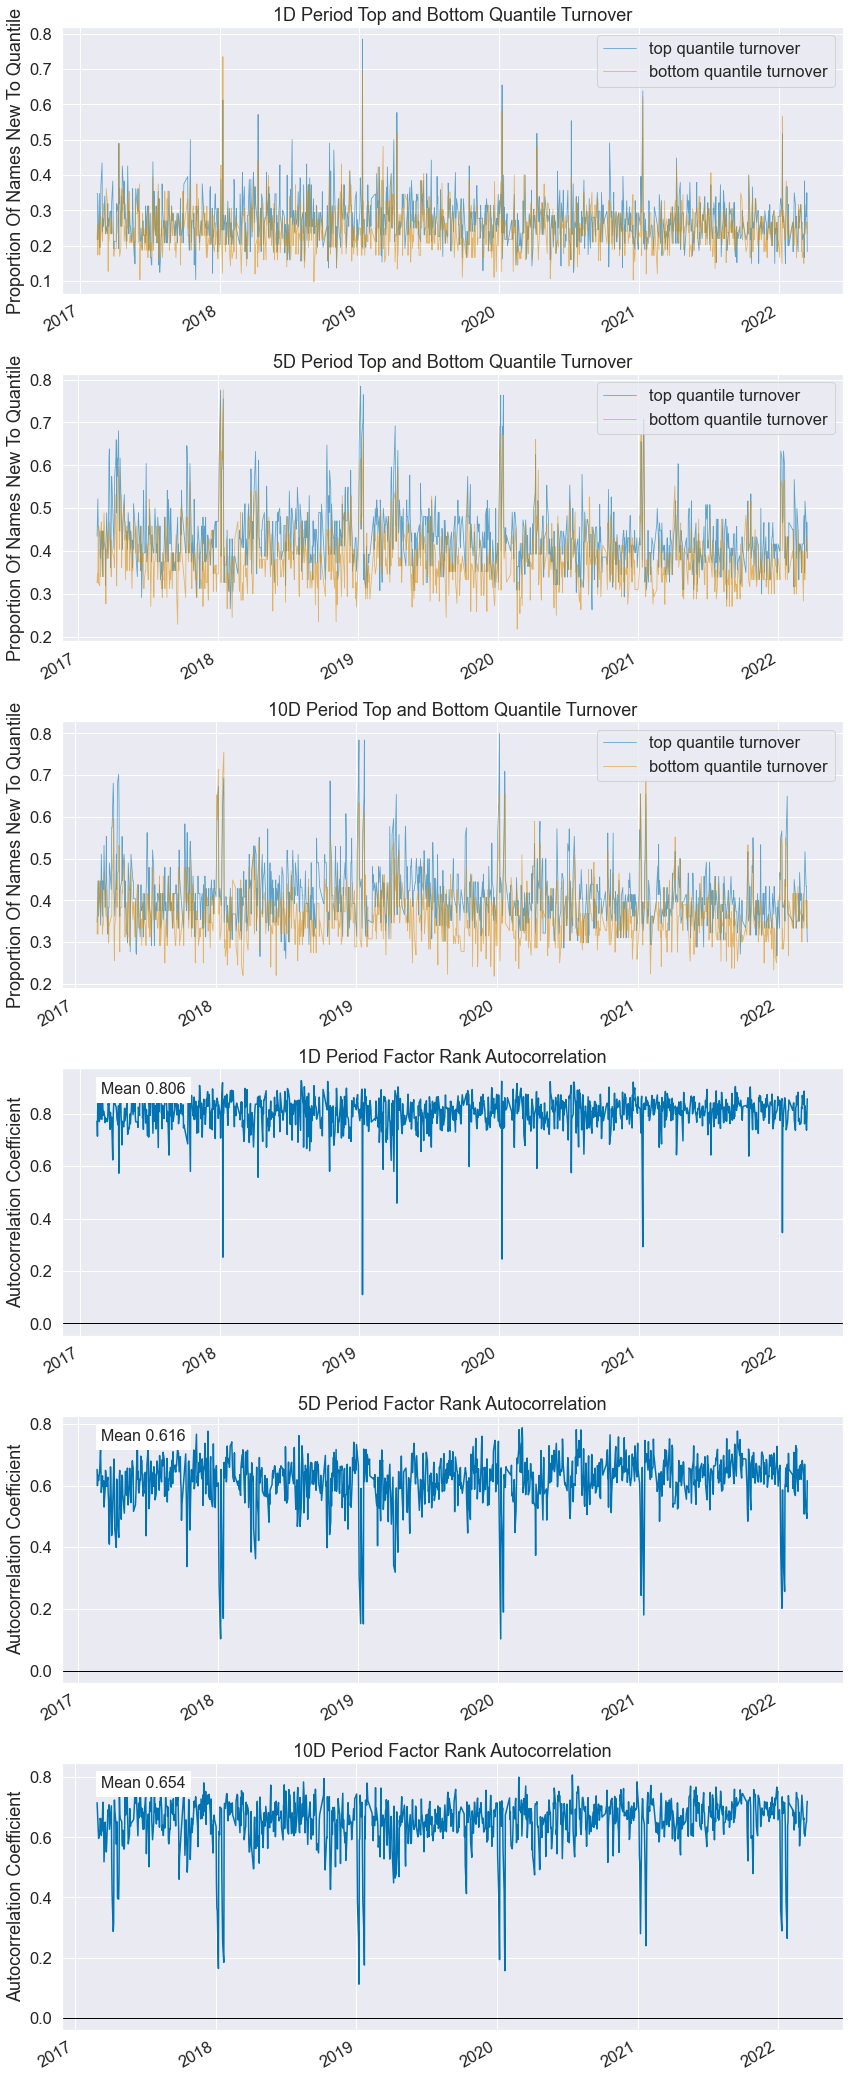

In [6]:
import alphalens as al
factor = data.set_index([data.index, data['code']], drop=True)
close = data.pivot_table(index='date', columns='code', values='close')

factor_data = al.utils.get_clean_factor_and_forward_returns(factor[['factor_predict']], close)
al.tears.create_full_tear_sheet(factor_data, group_neutral=False)